# CSE527 Homework 3
**Due date: 11:59 pm EST on April 10, 2022 (Sun.)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Using SIFT in OpenCV 3.x.x in Colab
---
The default version of OpenCV in Colab is 3.4.3. If we use SIFT method directly, typically we will get this error message:

```
error: OpenCV(3.4.3) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'

```

One simple way to use the OpenCV in-built function `SIFT` in Colab is to switch the version to the one from 'contrib'. Below is an example of switching OpenCV version:

1. Run the following command in one section in Colab, which has already been included in this assignment:
```
pip install opencv-contrib-python==3.4.2.16
```
2. Restart runtime by
```
Runtime -> Restart Runtime
```

Then you should be able to use use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object, whose functions are listed at http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html

## Some Resources
---
In addition to the tutorial document, the following resources can definitely help you in this homework:
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
- http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
- http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=sift#cv2.SIFT
- http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html





In [1]:
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 2.1 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import time
import zipfile
import torch
import torchvision
import gc
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans


print(cv2.__version__) # verify OpenCV version

3.4.2


In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
%cd '/content/gdrive/MyDrive/ColabNotebooks/CSE527-22S-HW3'


/content/gdrive/MyDrive/ColabNotebooks/CSE527-22S-HW3


## Problem 1: Object Recognition with HOG features
{25 points} You will use the histogram of oriented gradients (HOG) to extract features from objects and recognize them.

HOG decomposes an image into multiple cells, computes the direction of the gradients for all pixels in each cell, and creates a histogram of gradient orientation for that cell. Object recognition with HOG is usually done by extracting HOG features from a training set of images, learning a support vector machine (SVM) from those features, and then testing a new image with the SVM to determine the existence of an object.

You can use `cv2.ml.SVM_create` for SVMs. You can also use Python machine learning packages for SVM, e.g.`scikit-learn` and for HoG computation, e.g. `scikit-image`. Please find the OpenCV SVM tutorial at https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/.

An image set located under SourceImages/ETH-80 is provided containing images of two class: **apple** and **pear**. You will first train an SVM with the HoG features and then predict the class of an image with the trained SVM. The images have been split into training set (folder 1) and test set (folder 2).

Some of the function names and arguments are provided, you may change them as you need.

- **Step 1 (5pts)**. Load in the images and create a vector of corresponding labels (0 for apple and 1 for pear). An example label vector should be something like [1,1,1,1,1,0,0,0,0,0]. Display any four apple images and any four pear images of **training set** in a 2 x 4 grid with figsize = (20, 5).

- **Step 2 (10pts)**. Extract HoG features from all images. You can use hog routine from `scikit-image`. Display the HoG features for the four apple images and four pear images **chosen in step 1** in a 2 x 4 grid with figsize = (20, 5).

- **Step 3**. Shuffle your training date including features and labels. Reshape the HoG feature matrix as necessary to feed into the SVM. Train the classifier. **DO NOT train with test data.** No output is expected from this part.

- **Step 4 (10pts)**. Perform predictions with your trained SVM on the test data. Output a vector of predictions, a vector of ground truth labels, and prediction accuracy.

[reference of ETH-80 dataset] B. Leibe and, B.Schiele. Analyzing Appearance and Contour Based Methods for Object Categorization. CVPR, vol.2, pp. 409-415, 2003

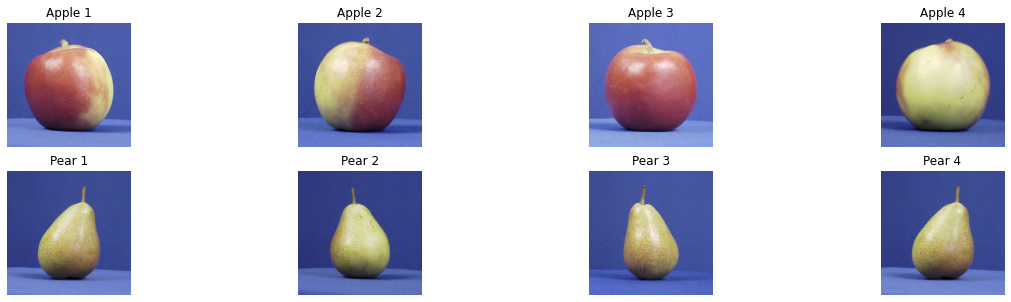

In [15]:
import skimage.exposure
from skimage.feature import hog
from sklearn.svm import LinearSVC
import os

def loadData(path):
  # you can use sorted(os.listdir(path)) to get all files under a directory
  ##########--WRITE YOUR CODE HERE--##########

  img = [cv2.imread(path + '/' + i, cv2.IMREAD_COLOR) for i in sorted(os.listdir(path))]

  ##########-------END OF CODE-------##########
  return img

imgs_train_0 = loadData('SourceImages/ETH-80/apple/1')
imgs_train_1 = loadData('SourceImages/ETH-80/pear/1')
imgs_test_0 = loadData('SourceImages/ETH-80/apple/2')
imgs_test_1 = loadData('SourceImages/ETH-80/pear/2')

# combine class 0 with class 1
imgs_train = imgs_train_1 + imgs_train_0
imgs_test = imgs_test_0 + imgs_test_1

# create class labels, assume apple = 0, pear = 1
labels_train = np.concatenate((np.ones(len(imgs_train_1)),np.zeros(len(imgs_train_0))), axis = None)
labels_test = np.concatenate((np.zeros(len(imgs_test_0)) , np.ones(len(imgs_test_1))), axis = None)


# display ANY 4 apple images and 4 pear images of TRAINING set 
# in a 2 x 4 grid with figsize = (20, 5)
##########--WRITE YOUR CODE HERE--##########

apples = []
apples_x = [i for i in range(len(labels_train)) if labels_train[i] == 0]
apples_rand = np.random.choice(apples_x,4)
for i in apples_rand:
  apples.append(imgs_train[i])

pears = []
pears_x = [i for i in range(len(labels_train)) if labels_train[i] == 1]
pears_rand = np.random.choice(pears_x,4)
for i in pears_rand:
  pears.append(imgs_train[i])

plt.figure(figsize=(20,5));

for j in range(4):
  plt.subplot(2,4,j+1);
  plt.imshow(cv2.cvtColor(apples[j], cv2.COLOR_BGR2RGB));
  plt.title('Apple ' + str(j+1))
  plt.axis('off')

for j in range(4):
  plt.subplot(2,4,j+5);
  plt.imshow(cv2.cvtColor(pears[j], cv2.COLOR_BGR2RGB));
  plt.title('Pear ' + str(j+1))
  plt.axis('off')


plt.show()


##########-------END OF CODE-------##########

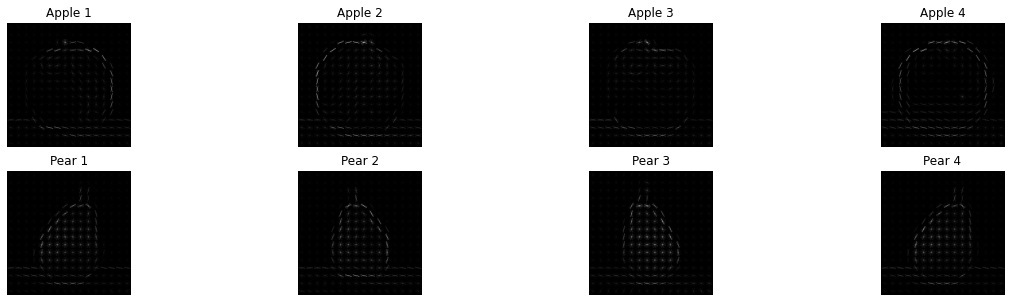

In [16]:
# Compute HOG features for the images
def computeHOGfeatures(image):
    # Compute HOG descriptors of a single image
    # you can use skimage.feature.hog and try your own parameters
    ##########--WRITE YOUR CODE HERE--##########
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_descriptor, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1, 1), visualize=True)

    ##########-------END OF CODE-------##########   
    return hog_descriptor, hog_image

def computeHOGfeaturesBatch(imgs):
    # Compute HOG descriptors of a batch of images
    ##########--WRITE YOUR CODE HERE--##########
    
    hog_descriptors, hog_images = [], []
    for img in imgs:
      hog_descriptor, hog_image = computeHOGfeatures(img)
      hog_descriptors.append(hog_descriptor)
      hog_images.append(hog_image)

    ##########-------END OF CODE-------##########
    return hog_descriptors, hog_images
  

Hogs_train, Hog_imgs_train = computeHOGfeaturesBatch(imgs_train)
Hogs_test, Hog_imgs_test = computeHOGfeaturesBatch(imgs_test)


# display hog images CORRESPONDING to the 4 apple and 4 pear images you chosed in previous step
# in a 2 x 4 grid with figsize = (20, 5)
##########--WRITE YOUR CODE HERE--##########

plt.figure(figsize=(20,5));
apples_hog_descriptors ,apples_hog_images = computeHOGfeaturesBatch(apples)
pears_hog_descriptors ,pears_hog_images = computeHOGfeaturesBatch(pears)

for j in range(4):
  plt.subplot(2,4,j+1);
  plt.imshow(apples_hog_images[j],'gray');
  plt.title('Apple ' + str(j+1))
  plt.axis('off')


for j in range(4):
  plt.subplot(2,4,j+5);
  plt.imshow(pears_hog_images[j], 'gray');
  plt.title('Pear ' + str(j+1))
  plt.axis('off')


plt.show()

##########-------END OF CODE-------########## 
  


In [17]:
# create a svm model and set your own hyper-parameters

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_RBF)
svm.setC(12.5)
svm.setGamma(0.50625)

# shuffle training data
import random
hogs_train_zip = list(zip(Hogs_train, labels_train))
random.shuffle(hogs_train_zip)
Hogs_train, labels_train = zip(*hogs_train_zip)

# train svm with training data

Hogs_train = np.float32(Hogs_train)
labels_train = np.asarray(labels_train, dtype= np.int32)
svm.train(Hogs_train, cv2.ml.ROW_SAMPLE, labels_train)

# make predictions on test data

Hogs_test = np.float32(Hogs_test)
labels_test_pred = svm.predict(Hogs_test)[1].ravel()

# print predictions and accuracy
print('Predicted labels: ', labels_test_pred.astype(np.int32).reshape([-1]))
print('Ground truth labels: ', labels_test.astype(np.int32).reshape([-1]))
print('Accuracy: ', np.mean(labels_test_pred.astype(np.int32)==labels_test.astype(np.int32))*100, '%')

Predicted labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Ground truth labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy:  53.125 %


## Problem 2: Estimate Depth with Stereo
## Description
----
{35 points} In this problem, you will be estimating depth with stereo. The two images are taken in the geometry of a simple stereo system illustrated in the slide (see Page 4 of CSE527-stereo.pdf). The system parameters are given below. You will obtain the depth map from disparity. Assuming the two images have been rectificated. In other words, the corresponding point in the right image appears in the same row as the point in the left image. You need to obtain the corresponding points in the right image to all points in the left image. To do this, you will first use Normalized Cross Correlation, then use the more efficient dynamic programming [(Cox et al. '96)](http://www.sciencedirect.com/science/article/pii/S1077314296900405/pdf?md5=78740d9c766e2f13b69cbd4ab5b3981d&pid=1-s2.0-S1077314296900405-main.pdf). After you get the disparity, you can calculate the depth map by solving the similarity in triangles.



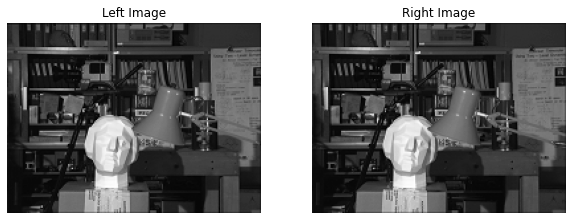

In [5]:
imgL = cv2.imread('SourceImages/tsukuba_l.png', 0)
imgR = cv2.imread('SourceImages/tsukuba_r.png', 0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Left Image')
plt.imshow(imgL, cmap ='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title('Right Image')
plt.imshow(imgR, cmap ='gray')
plt.axis("off")
plt.show()

In [6]:
# System parameters, DO NOT MODIFY them
focalL = 96.0  # focal length
baseline = 100  # baseline

def NCC(src, dst):
  ##########--WRITE YOUR CODE HERE--##########
  # remember to translate so that mean is zero
  
  src_translated = src -np.mean(src)
  dst_translated = dst -np.mean(dst)

  n = len(src_translated) * len(src[0])
  src = src_translated.reshape(1, n)
  dst = dst_translated.reshape(1, n)

  ncc = float(np.dot(src, dst.T)/(np.linalg.norm(src, 2)*np.linalg.norm(dst, 2)))

  ##########-------END OF CODE-------##########
  return ncc

NCC_imageL2R = NCC(imgL, imgR)
print('The NCC between left and right image is {}'.format(NCC_imageL2R))

The NCC between left and right image is 0.7568264241977167


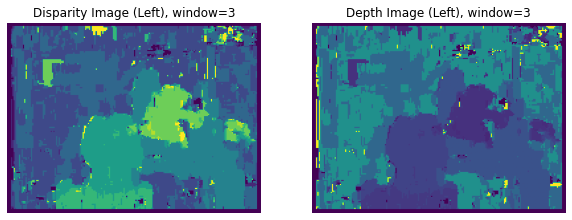

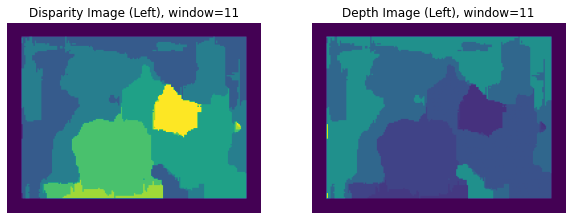

In [7]:
def find_disp_NCC(imgL, imgR, win=5):
  ##########--WRITE YOUR CODE HERE--##########
  # find the disparity of left image with NCC
  
  l = np.ones(imgL.shape)
  r = np.ones(imgR.shape)
  img_dispL = np.zeros(imgL.shape)
  l[imgL > 0] = imgL[imgL > 0]
  r[imgR > 0] = imgR[imgR > 0]

  h, w = imgL.shape  
  max_offset = 10    
  offset_adjust = 255 / max_offset  
    
  for y in range(win, h - win):       
    for x in range(win, w - win):
      best_offset = 0
      prev_ncc = 0
      
      for offset in range(max_offset):               
        ncc = 0
        ncc_num = 0                            
        ncc_d1 = 0
        ncc_d2 = 0
        ncc_src_sum = 0
        ncc_dest_sum = 0
        n = 0

        for v in range(-win, win):
          for u in range(-win, win):
            ncc_src_sum += int(l[y+v][x+u])
            ncc_dest_sum += int(r[y+v][(x+u) - offset])
            n += 1
        ncc_src_mean = ncc_src_sum/n
        ncc_dest_mean = ncc_dest_sum/n      

        for v in range(-win, win):
          for u in range(-win, win):
            src = l[y+v][x+u] - ncc_src_mean
            dest = r[y+v][(x+u) - offset] - ncc_dest_mean
            ncc_num += src*dest
            ncc_d1 += src**2
            ncc_d2 += dest**2
        ncc_denom = ncc_d1 *ncc_d2
        ncc = ncc_num/np.sqrt(ncc_denom)

        if ncc > prev_ncc:
          prev_ncc = ncc
          best_offset = offset
       
      img_dispL[y][x] = best_offset * offset_adjust      

  ##########-------END OF CODE-------##########
  return img_dispL         

def get_depth_map(img_dispL, baseline, focalL):
  ##########--WRITE YOUR CODE HERE--##########
  # get depth map from disparity
  # be careful with dividing by 0
  
  img_depthL = np.zeros(img_dispL.shape)
  img_depthL[img_dispL > 0] = baseline * focalL / img_dispL[img_dispL > 0]

  ##########-------END OF CODE-------##########
  return img_depthL

win = 3
img_dispL = find_disp_NCC(imgL, imgR, win)

# plot disparity image and depth image
plt.figure(figsize=(10, 5));
plt.subplot(1, 2, 1);
plt.title('Disparity Image (Left), window={}'.format(win));
plt.imshow(img_dispL);
plt.axis("off");

img_depthL = get_depth_map(img_dispL, baseline, focalL)
plt.subplot(1, 2, 2);
plt.title('Depth Image (Left), window={}'.format(win));
plt.imshow(img_depthL);
plt.axis("off");

win = 11
img_dispL = find_disp_NCC(imgL, imgR, win)

# plot disparity image and depth image
plt.figure(figsize=(10, 5));
plt.subplot(1, 2, 1);
plt.title('Disparity Image (Left), window={}'.format(win));
plt.imshow(img_dispL);
plt.axis("off");

img_depthL = get_depth_map(img_dispL, baseline, focalL)
plt.subplot(1, 2, 2);
plt.title('Depth Image (Left), window={}'.format(win));
plt.imshow(img_depthL);
plt.axis("off");

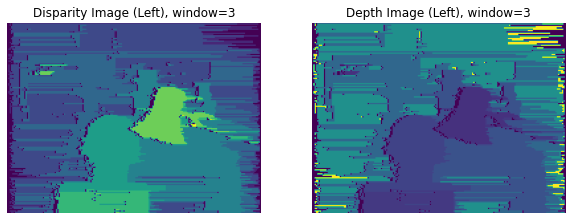

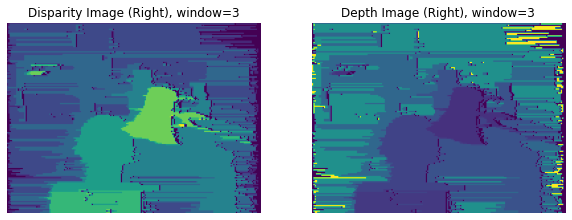

In [8]:
def find_disp_DP(imgL, imgR, win=3, occlusion_cost = 30):
  ##########--WRITE YOUR CODE HERE--##########
  # find the disparity of left and right image with DP
  imgL = imgL.astype('float64')
  imgR = imgR.astype('float64')
  row,col = imgL.shape
  img_dispL = np.zeros((row,col))
  img_dispR = np.zeros((row,col))  

  for r in range(0, row):
    cost = np.zeros((col,col))
    path = np.ones((col,col))

    for i in range(1,col):
      cost[i][0] = i * occlusion_cost
      cost[0][i] = i * occlusion_cost 

    for i in range(1,col):
      for j in range(1,col):
        temp = np.abs(imgL[r][i-1] - imgR[r][j-1])
        min1 = cost[i-1][j-1] + temp
        min2 = cost[i-1][j] + occlusion_cost
        min3 = cost[i][j-1] + occlusion_cost
        cmin = min(min1,min2,min3)
        cost[i][j] = cmin
        if(cmin == min1):
          path[i][j] = 1
        elif (cmin == min2):
          path[i][j] = 2
        elif (cmin == min3):
          path[i][j] = 3

    i = col - 1
    j = col - 1

    while i!=0 and j!=0:
      if path[i][j] == 1:
        i -= 1
        j -= 1
        img_dispL[r][i] = abs(i - j)
        img_dispR[r][j] = abs(j - i)
        
      elif path[i][j] == 2:
        i -= 1
        img_dispL[r][i] = 0
        
      elif path[i][j] == 3:
        j -= 1
        img_dispR[r][j] = 0
 
  ##########-------END OF CODE-------##########
  return img_dispL, img_dispR 



win = 3
img_dispL, img_dispR = find_disp_DP(imgL, imgR, win)

# plot disparity image and depth image
plt.figure(figsize=(10, 5));
plt.subplot(1, 2, 1);
plt.title('Disparity Image (Left), window={}'.format(win));
plt.imshow(img_dispL);
plt.axis("off");

img_depthL = get_depth_map(img_dispL, baseline, focalL)
plt.subplot(1, 2, 2);
plt.title('Depth Image (Left), window={}'.format(win));
plt.imshow(img_depthL);
plt.axis("off");

# plot disparity image and depth image
plt.figure(figsize=(10, 5));
plt.subplot(1, 2, 1);
plt.title('Disparity Image (Right), window={}'.format(win));
plt.imshow(img_dispR);
plt.axis("off");

img_depthR = get_depth_map(img_dispR, baseline, focalL)
plt.subplot(1, 2, 2);
plt.title('Depth Image (Right), window={}'.format(win));
plt.imshow(img_depthR);
plt.axis("off");

## Problem 3: Image Classification with Bag of SIFT Representation + SVM Classifer

## Description
---
In this problem, we will examine the task of image classification using bags of quantized local features and linear classifiers learned by support vector machines. We will implement a basic bag of words model and
classify images into one of 10 categories by training and testing on **a small subset** of **miniImagenet** dataset (downloaded from https://awesomeopensource.com/project/oscarknagg/few-shot).

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.



## Data Preparation
----

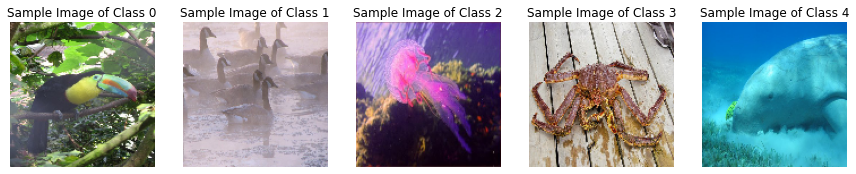

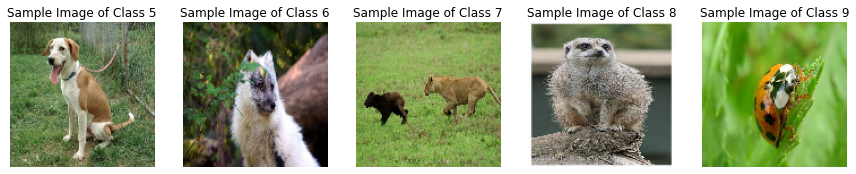

In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_train = pickle.load(fo, encoding='bytes')
        dict_test = pickle.load(fo, encoding='bytes')
    return dict_train, dict_test

# load data from pickle files and sample a small subset for this homework
train_data_dict, test_data_dict = unpickle('miniImageNet.pkl') 
train_label = train_data_dict['labels']  
train_data = train_data_dict['data']  

test_label = test_data_dict['labels']   
test_data = test_data_dict['data'] 

# reshape data
train_data = [d.reshape(3, 128, 128).transpose(1,2,0) for d in train_data]
test_data = [d.reshape(3, 128, 128).transpose(1,2,0) for d in test_data]

# plot 10 training images from 10 classes
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title('Sample Image of Class {}'.format(i))
    plt.imshow(cv2.cvtColor(train_data[500*i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title('Sample Image of Class {}'.format(i+5))
    plt.imshow(cv2.cvtColor(train_data[500*(i+5)], cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()

## Problem 3.a: Bag of SIFT Representation 
{25 points}
Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. 

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 200 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 200. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.


**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to **densely sample keypoints** in a grid with certain step
  size (sampling density) and scale. 
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary.



**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use [`cv2.Keypoint()`](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint) to generate key points;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints.

- Be mindful of RAM usage. Try to make the code more memory efficient, otherwise it could easily exceed RAM limits in Colab, at which point your session will crash.
- If your RAM is going to run out of space, use [gc.collect()](https://docs.python.org/3/library/gc.html) for the garbage collector to collect unused objects in  memory to free some space.
- Store data or features as NumPy arrays instead of lists. Computation on NumPy arrays is much more efficient than lists.

In [10]:
from sklearn import neighbors

np.random.seed(56)

##########--WRITE YOUR CODE HERE--##########
# The following steps are just for your reference
# You can write in your own way

# densely sample keypoints
def sample_kp(shape, stride, size):
  kp = []
  for i in range(0, shape[0], stride[0]):
    for j in range(0, shape[1], stride[1]):
      kp.append(cv2.KeyPoint(j,i,size))  
  return kp

# extract vocabulary of SIFT features
def extract_vocabulary(raw_data, key_point):
  dp = []
  # create SIFT feature extractor
  sift = cv2.xfeatures2d.SIFT_create()
  for img in raw_data:
    kps, desc = sift.compute(img, key_point)
    dp.append(desc)
  vocabulary =  np.array(dp)
  return vocabulary

# extract Bag of SIFT Representation of images
def get_kmeans(c, vocabulary):
  if len(vocabulary.shape) == 1:
    kmeans = KMeans(n_clusters=c, verbose=0).fit(vocabulary)
  else:
    kmeans = KMeans(n_clusters=c, verbose=0).fit(vocabulary.reshape(-1, 128))
  return kmeans
    
def extract_feat(vocabulary, kmeans):
  histogram = []
  for des in vocabulary:
    hist = np.zeros(n_clusters)
    hist[kmeans.predict(des.reshape((-1,128)))] += 1
    histogram.append(hist)
  histogram = np.array(histogram)
  return histogram
 
# sample dense keypoints 
skp = sample_kp((train_data[0].shape[0],train_data[0].shape[1]),(64,64), 8)

train_vocabulary = extract_vocabulary(train_data, skp)
test_vocabulary = extract_vocabulary(test_data, skp)

n_clusters = 64
kmeans = get_kmeans(n_clusters, train_vocabulary) 

train_feat = extract_feat(train_vocabulary, kmeans)
test_feat = extract_feat(test_vocabulary, kmeans)

##########-------END OF CODE-------##########
# this block should generate 
# train_feat and test_feat corresponding to train_data and test_data

## Problem 3.b: one-vs-all SVMs
{15 points}
You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 10-way classification problem
(the library has handled it for you). To decide which of 10 categories a test
case belongs to, you will train 10 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'bird' vs 'non-bird',
'cat' vs 'non-cat', etc. All 10 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'cat' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'bird' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
'cat' even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
**C** which controls how strongly regularized the model is. Your
accuracy will be very sensitive to **C**, so be sure to try many values.


**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [14]:
from sklearn import svm

##########--WRITE YOUR CODE HERE--##########
# The following steps are just for your reference
# You can write in your own way

def train_SVM(X, Y):
  clf = svm.LinearSVC(C = 1).fit(X, Y)
  return clf
 
def predict_SVM(clf, X):
  predict = clf.predict(X)
  return predict
   
clf = train_SVM(train_feat, train_label)
 
# make predictions on test data
prediction = [-1]*len(test_feat)
for i in range(len(test_feat)):
    prediction[i] = predict_SVM(clf, np.reshape(test_feat[i],(1,-1)))
 
test_label_pred = np.reshape(np.array(prediction),(-1,))

##########-------END OF CODE-------##########
accuracy = sum(np.array(test_label_pred) == test_label) / float(len(test_label))
print("The accuracy of Bag of SIFT Representation + one-vs-all SVMs model is {:.2f}%".format(accuracy*100))

The accuracy of Bag of SIFT Representation + one-vs-all SVMs model is 23.00%


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw3' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
```

For instance, student Michael Jordan should submit a zip file named "Lecun_Yann_111134567_hw3.zip" for homework3 in this structure:
```
Lecun_Yann_111134567_hw3
        |---Lecun_Yann_111134567_hw3.ipynb
        |---Lecun_Yann_111134567_hw3.pdf
```

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's emails: ***haoyuwu@cs.stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard. 

Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw3' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.
